# Random walks for identifying WUJ pages

After representing gov.uk as a network, pages are nodes and links between them are edges. A random walk is initialised at a given node, then successively transitions to adjacent nodes by traversing edges. Each node is assigned a probability of being selected. We consider the cases where those transition probabilities are all equal and unequal (biased random walk).

Random walks are inclined to become trapped within communities of nodes. A community is a set of nodes for which connections between nodes in the community are more numerous than connections to nodes outside the community. Hence, this "trapping" behaviour arises from the fact that there are more opportunities to transition to nodes within the same community than there are opportunities to transition to a node outside the community.

The hope is that pages within a WUJ exhibit community structure. If so, a random walk initialised within a WUJ would spend most of its time transitioning between nodes within that WUJ. Tracking what those nodes are provides a set of pages related to a WUJ.

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import src.utils.randomwalks as rw
from itertools import combinations
from random import sample
from bokeh.io import output_notebook, show, save
from bokeh.models import Circle, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.models import NodesAndLinkedEdges
import plotly.express as px
import os

You can visit this G Drive folder to get the data for this project: https://drive.google.com/drive/folders/1E-pxqkJDrS-jd_MNq6IbS-v7gGNNmrYd?usp=sharing
Or, alternatively, run the code below to use the Google API to retrieve data from that same G Drive folder.

In [ ]:
import gspread 
from oauth2client.service_account import ServiceAccountCredentials

GOOGLE_APPLICATION_CREDENTIALS = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')

# Connect to service account
scope = ['https://spreadsheets.google.com/feeds'] 
credentials = ServiceAccountCredentials.from_json_keyfile_name(GOOGLE_APPLICATION_CREDENTIALS, scope) 
gc = gspread.authorize(credentials)

### Read graph

In [ ]:
# get networkx graph
G = nx.read_gpickle("../../data/processed/5_hits_per_contentID_graph.gpickle")

# get SaB pages
# Import the data from google sheets
spreadsheet_key = '1x3lHpUkIm-KTnWrRJU11An1J2Yb4KJT8z0QpuXOm3e0' 
book = gc.open_by_key(spreadsheet_key) 
worksheet = book.worksheet('sab_pages') 
table = worksheet.get_all_values()
# Convert table data into a dataframe then set 
sab_pages = pd.DataFrame(table[1:], columns=table[0]).pagePath.tolist()

# get economic recovery pages
# Import the data from google sheets
spreadsheet_key = '1lLsgQRsl4bXmbyiwrbMNQOR_Zu-FkbqYRUmOOhTYc70' 
book = gc.open_by_key(spreadsheet_key) 
worksheet = book.worksheet('Top pages') 
table = worksheet.get_all_values()
# Convert table data into a dataframe then set 
er_pages = pd.DataFrame(table[1:], columns=table[0]).pagePathv2.tolist()

# get adjacency matrix of G
A = nx.adj_matrix(G, weight=None)

### Brief analysis of network structure

#### Size of connected components

Strongly connected components in the entire subgraph:

In [ ]:
strong_components = [G.subgraph(c) for c in nx.strongly_connected_components(G)]
sorted([g.number_of_nodes() for g in strong_components], reverse=True)[:10]

In [ ]:
print(nx.info(G))

There is one large mass of 34,541 nodes, leaving 18,696 nodes in smaller connected components. Hence, viewing the graph as directed leaves much of the graph inaccessible if random walks are initialised in the largest connected component.

Weakly connected components in the entire subgraph:

In [ ]:
weak_components = [G.subgraph(c) for c in nx.weakly_connected_components(G)]
sorted([g.number_of_nodes() for g in weak_components], reverse=True)[:10]

Ignoring edge direction groups together 97% of the nodes into a single component, meaning very few nodes are inaccesible if a random walk is initialised in the largest component.

Let's examine our WUJ pages now.

First, start a business pages:

In [ ]:
# create a subgraph from SaB pages
sab_graph = G.subgraph([node[0] for node in G.nodes(data=True) if node[1]['properties']['name'] in sab_pages])

In [ ]:
strong_sab_components = [sab_graph.subgraph(c) for c in nx.strongly_connected_components(sab_graph)]
sorted([g.number_of_nodes() for g in strong_sab_components], reverse=True)[:10]

In [ ]:
weak_sab_components = [sab_graph.subgraph(c) for c in nx.weakly_connected_components(sab_graph)]
sorted([g.number_of_nodes() for g in weak_sab_components], reverse=True)[:10]

If a random walk were only to visit nodes within the SaB WUJ, some nodes will be accessible whether edge direction is ignored or not. Hence, a random walk either needs to be able to leave the space of SaB pages, in order to traverse to smaller components, or be able to perturb its position and land in another component of SaB pages.

89% of pages are within the largest weakly connected component, hence, a random walk will potentially have more ease in finding SaB pages on an undirected graph than a directed graph.

In [ ]:
rw.showGraph(sab_graph, figsize=(10,10))

In [ ]:
rw.showGraph(sab_graph.to_undirected(), figsize=(10,10))

Now, economic recovery pages:

In [ ]:
# create a subgraph from ER pages
er_graph = G.subgraph([node[0] for node in G.nodes(data=True) if node[1]['properties']['name'] in er_pages])

In [ ]:
strong_er_components = [er_graph.subgraph(c) for c in nx.strongly_connected_components(er_graph)]
sorted([g.number_of_nodes() for g in strong_er_components], reverse=True)[:10]

In [ ]:
weak_er_components = [er_graph.subgraph(c) for c in nx.weakly_connected_components(er_graph)]
sorted([g.number_of_nodes() for g in weak_er_components], reverse=True)[:10]

In [ ]:
rw.showGraph(er_graph, figsize=(10,10))

In [ ]:
rw.showGraph(er_graph.to_undirected(), figsize=(10,10))

Similarly with economic recovery pages, ignoring edge direction leads to greater interconnectivity between nodes in this WUJ.

Overall conclusion: undirected graphs are likely to be more consistent with performant random walks than directed graphs.

### Interactive graph

This interative graph allows you to pan, zoom and investigate the structure of a graph.

In [ ]:
# get networkx graph as undirected network
G = G.to_undirected()

# G_simple will become a simplified version of G that can be plotted with Bokeh
# because the original G has nested dictionaries in it, which Bokeh doesn't like
G_simple = G.copy()


Now adding colour attributes to nodes for the bokeh plot.

In [ ]:
wuj_colours = {
    'none': 'white',
    'sab': 'red',
    'er': 'blue'
}

wuj_highlight_colours = {
    'none': 'green',
    'sab': 'orange',
    'er': 'purple'
}

wuj_pages = {
    'sab': set(sab_pages),
    'er': set(er_pages)
}

for id in G_simple.nodes:
    G_simple.nodes[id]['wuj'] = 'none'
    G_simple.nodes[id]['wuj_colour'] = wuj_colours['none']
    G_simple.nodes[id]['title'] = G_simple.nodes[id]['properties']['title']
    for key, value in wuj_pages.items():
        if G_simple.nodes[id]['properties']['name'] in value:
            G_simple.nodes[id]['wuj'] = key
            G_simple.nodes[id]['wuj_colour'] = wuj_colours[key]
            break

Now adding colour attributes to edges for the bokeh plot.

In [ ]:
for i,j,data in G_simple.edges(data=True):
    data['wuj_edge_colour'] = 'black'
    data['edge_highlight_colour'] = '#027600'
    data['edge_alpha'] = 0.1

In [ ]:
sab_graph = G_simple.subgraph([node[0] for node in G.nodes(data=True) if node[1]['properties']['name'] in sab_pages])

In [ ]:
for i,j,data in sab_graph.edges(data=True):
    data['wuj_edge_colour'] = 'red'
    data['edge_highlight_colour'] = 'orange'
    data['edge_alpha'] = 0.5

In [ ]:
sab_ids = [id for id,data in G.nodes(data=True) if data['properties']['name'] in sab_pages]
sab_neighbourhood = [list(nx.generators.ego_graph(G, sab_id, radius=1).nodes) for sab_id in sab_ids]
sab_neighbourhood = set.union(*map(set, sab_neighbourhood))
sab_neighbour_graph = G_simple.subgraph(sab_neighbourhood)

In [ ]:
er_graph = G_simple.subgraph([node[0] for node in G.nodes(data=True) if node[1]['properties']['name'] in er_pages])

In [ ]:
for i,j,data in er_graph.edges(data=True):
    data['wuj_edge_colour'] = 'blue'
    data['edge_highlight_colour'] = '#E60CEC'
    data['edge_alpha'] = 0.5

In [ ]:
er_ids = [id for id,data in G.nodes(data=True) if data['properties']['name'] in er_pages]
er_neighbourhood = [list(nx.generators.ego_graph(G, er_id, radius=1).nodes) for er_id in er_ids]
er_neighbourhood = set.union(*map(set, er_neighbourhood))
er_neighbour_graph = G_simple.subgraph(er_neighbourhood)

Deleting all the nested dictionaries from the graph, to stop Bokeh from crying.

In [ ]:
for node in G_simple.nodes(data=True):
    try:
        del node[1]['labels']
    except:
        pass
    try:
        del node[1]['properties']
    except:
        pass
    try:
        del node[1]['size']
    except:
        pass

Now plotting the Bokeh graph. All of this code was shamelessly stolen (and adapted) from here: https://melaniewalsh.github.io/Intro-Cultural-Analytics/06-Network-Analysis/02-Making-Network-Viz-with-Bokeh.html#dataset

In [ ]:
output_notebook()

#Choose colors for node and edge highlighting
node_highlight_color = 'white'
edge_highlight_color = 'green'

#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
color_by_this_attribute = 'wuj_colour'
edge_color_by_this_attribute = 'wuj_edge_colour'
edge_alpha_by_this_attribute = 'edge_alpha'
edge_highlight_color_by_this_attribute = 'edge_highlight_colour'

#Choose a title!
title = 'SaB Neighbour Graph'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ('WUJ', '@wuj'),
       ('Title', '@title')
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',title=title,
            plot_width=1400, plot_height=800)

#Create a network graph object
network_graph = from_networkx(sab_neighbour_graph, nx.kamada_kawai_layout, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(fill_color=color_by_this_attribute)

#Set node highlight colors
network_graph.node_renderer.hover_glyph = Circle(fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(fill_color=node_highlight_color, line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=edge_alpha_by_this_attribute, line_width=1, line_color=edge_color_by_this_attribute)

#Set edge highlight colors
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color_by_this_attribute, line_width=1.5)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color_by_this_attribute, line_width=1.5)

#Highlight nodes and edges
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)

show(plot)
save(plot, filename=f"{title}.html")

Loading BokehJS ...

'/Users/jakerutherford/Documents/govuk-wuj-network-analysis/notebooks/SaB Neighbour Graph.html'

# Random walks

In [ ]:
# get networkx graph as undirected network
G = G.to_undirected()

# get adjacency matrix of G
A = nx.adj_matrix(G, weight=None)

## Naive random walk

Here we're testing the most basic form of random walk, in which a random walk is initialised from a seed page, thereafter successively transitioning to neighbouring nodes, with uniformly distributed transition probabilities. repeats=100 random walks are initialised per seed node. Each random walk performs steps=500 steps. For a given seed node, the precision and recall are computed per random walk, then these precisions and recalls are averaged to get an average precision and recall per seed node. Repeat random walks are used to get a sense of typical performance, rather than the analysis being victim of fluke random walks. Precision gives the proportion of unique pages visited that belong to a given WUJ. Recall gives the proportion of pages from a WUJ that were found.

### Start a business (SaB)

In [ ]:
results = rw.repeat_random_walks(steps=500, repeats=100, T=A, G=G, seed_pages=sab_pages, proba=False, combine='no', n_jobs=-1)
seed_paths = results['pages_visited']
scores = np.matrix([np.mean([rw.evaluate(results['seeds'], path) for path in paths], axis=0) for paths in seed_paths])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Mean precision and recall for start a business seed pages')
ax[0].hist(scores[:,0]);
ax[0].set_title("Precision");
ax[0].set_xlabel("Percentage");
ax[1].hist(scores[:,1]);
ax[1].set_title("Recall");
ax[1].set_xlabel("Percentage");

In [ ]:
np.mean(scores, axis=0)

In [ ]:
results = rw.repeat_random_walks(steps=10, repeats=2, T=A, G=G, seed_pages=er_pages[:10], proba=False, combine='no', n_jobs=1)

### Economic recovery

In [ ]:
results = rw.repeat_random_walks(steps=500, repeats=100, T=A, G=G, seed_pages=er_pages, proba=False, combine='no', n_jobs=-1)
seed_paths = results['pages_visited']
scores = np.matrix([np.mean([rw.evaluate(er_pages, path) for path in paths], axis=0) for paths in seed_paths])

['/business-finance-support', 'http://great.gov.uk/campaigns/internationalisation-fund-for-english-businesses/', '/employing-an-apprentice/get-funding', '/universal-credit/other-financial-support', '/become-apprentice/pay-and-conditions', '/become-apprentice/pay-and-conditions', '/advanced-learner-loan/how-to-apply', '/further-education-courses/find-a-course'] could not be found in the graph


  0%|          | 0/40 [00:00<?, ?it/s]

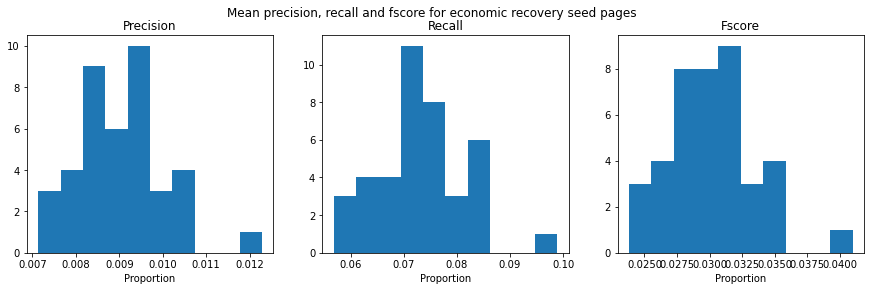

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle('Mean precision, recall and fscore for economic recovery seed pages')
ax[0].hist(scores[:,0]);
ax[0].set_title("Precision");
ax[0].set_xlabel("Proportion");
ax[1].hist(scores[:,1]);
ax[1].set_title("Recall");
ax[1].set_xlabel("Proportion");
ax[2].hist(scores[:,2]);
ax[2].set_title("Fscore");
ax[2].set_xlabel("Proportion");

In [ ]:
np.mean(scores, axis=0)

matrix([[0.00902419, 0.07305978, 0.03014909]])

Average precision, recall and fscore are 0.009, 0.073 and 0.03, respectively. Wide range of performance according to seed page choice. Five best seed nodes, according to fscore are below:

In [ ]:
sorted(list(zip(scores[:,2], results['seeds'])), key=lambda x: -x[0])[:5]

[(matrix([[0.04098602]]),
  '/education/further-and-higher-education-courses-and-qualifications'),
 (matrix([[0.0354459]]), '/agricultural-skills-and-training'),
 (matrix([[0.03491056]]), '/career-skills-and-training'),
 (matrix([[0.03443405]]), '/grant-bursary-adult-learners'),
 (matrix([[0.03438142]]), '/improve-english-maths-it-skills')]

## Repeated random walk

Previously, a random walk would return its own set of unique pages visited. Now, we will combine the pages visited by multiple random walks into a single set and evaluate the precision, recall and fscore of that set against manually curated WUJ pages. The motivation for this is that random walks can go in different directions. Hence, one finite random walk alone is unlikely to find all of the relevant WUJ pages.

### Single seed node

Initially, this experiment combines repeats=10 random walks initialised per seed node. Hence, each seed node gets one set of pages visited.

#### Start a business

In [ ]:
results = rw.repeat_random_walks(steps=500, repeats=10, T=A, G=G, seed_pages=sab_pages, proba=False, combine='union', n_jobs=-1)
seed_paths = results['pages_visited']
scores = np.matrix([rw.evaluate(results['seeds'], path) for path in seed_paths])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle('Precision, recall and fscore for SaB seed pages')
ax[0].hist(scores[:,0]);
ax[0].set_title("Precision");
ax[0].set_xlabel("Proportion");
ax[1].hist(scores[:,1]);
ax[1].set_title("Recall");
ax[1].set_xlabel("Proportion");
ax[2].hist(scores[:,2]);
ax[2].set_title("Fscore");
ax[2].set_xlabel("Proportion");

In [ ]:
np.mean(scores, axis=0)

In [ ]:
np.mean([len(seed_path) for seed_path in seed_paths])

#### Economic Recovery

In [ ]:
results = rw.repeat_random_walks(steps=500, repeats=10, T=A, G=G, seed_pages=er_pages, proba=False, combine='union', n_jobs=-1)
seed_paths = results['pages_visited']
scores = np.matrix([rw.evaluate(results['seeds'], path) for path in seed_paths])

['/business-finance-support', 'http://great.gov.uk/campaigns/internationalisation-fund-for-english-businesses/', '/employing-an-apprentice/get-funding', '/universal-credit/other-financial-support', '/become-apprentice/pay-and-conditions', '/become-apprentice/pay-and-conditions', '/advanced-learner-loan/how-to-apply', '/further-education-courses/find-a-course'] could not be found in the graph


  0%|          | 0/40 [00:00<?, ?it/s]

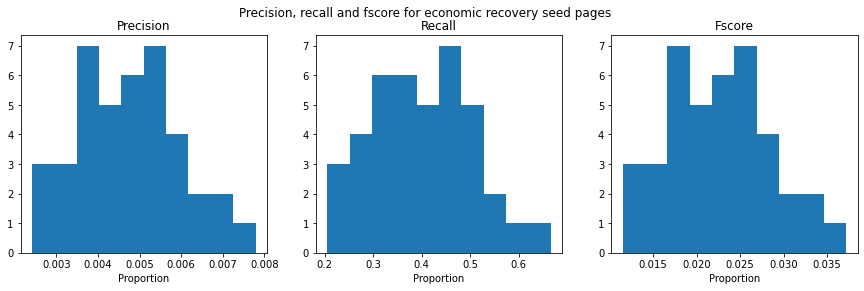

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle('Precision, recall and fscore for economic recovery seed pages')
ax[0].hist(scores[:,0]);
ax[0].set_title("Precision");
ax[0].set_xlabel("Proportion");
ax[1].hist(scores[:,1]);
ax[1].set_title("Recall");
ax[1].set_xlabel("Proportion");
ax[2].hist(scores[:,2]);
ax[2].set_title("Fscore");
ax[2].set_xlabel("Proportion");

In [ ]:
np.mean(scores, axis=0)

matrix([[0.00475558, 0.39935897, 0.02269643]])

In [ ]:
np.mean([len(seed_path) for seed_path in seed_paths])

3275.0

Under these initial conditions of repeats=10 and steps=500, combining the M paths into a single set of pages per seed node boosts recall significantly. An average of 19/48 economic recovery pages are found. Howevever, precision is unacceptable, requiring 3275 unique pages to be visited, on average, to discover those 19 economic recovery pages.

### Multiple seed nodes

Now the pages visited are merged together across multiple seed nodes. For a given WUJ, we identify 3 seed nodes. 'repeats' many random walks are initialised per seed node. This gives 3*repeats sets of pages, for which the union is taken. Hence, the 3*repeats sets become a single set.

We cannot exhaustively trial every possible combination of 3 pages within a WUJ. For instance, economic recovery has 46 pages, and there are 15,180 combinations of 3 pages from a set of 46 pages. Hence, a sample of 3 page combinations is generated.

#### Start a business

In [ ]:
sab_seed_samples = sample(list(combinations(sab_pages,3)),20)

In [ ]:
ps = []
rs = []
fs = []

for seed_sample in tqdm(sab_seed_samples):
    result = rw.repeat_random_walks(500,10,A,G,seed_sample,proba=False,combine='union',level=1,verbose=0,n_jobs=-1)
    p,r,f = rw.evaluate(sab_pages, result['pages_visited'])
    ps.append(p)
    rs.append(r)
    fs.append(f)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle('Precision, recall and fscore for combinations of SaB seed pages')
ax[0].hist(ps);
ax[0].set_title("Precision");
ax[0].set_xlabel("Proportion");
ax[1].hist(rs);
ax[1].set_title("Recall");
ax[1].set_xlabel("Proportion");
ax[2].hist(fs);
ax[2].set_title("Fscore");
ax[2].set_xlabel("Proportion");

In [ ]:
np.mean([ps,rs,fs], axis=1)

In [ ]:
sorted(list(zip(fs, sab_seed_samples)), key=lambda x: -x[0])[:5]

#### Economic recovery

In [ ]:
er_seed_samples = sample(list(combinations(er_pages,3)),20)

In [ ]:
ps = []
rs = []
fs = []

for seed_sample in tqdm(er_seed_samples):
    result = rw.repeat_random_walks(500,10,A,G,seed_sample,proba=False,combine='union',level=1,verbose=0,n_jobs=-1)
    p,r,f = rw.evaluate(er_pages, result['pages_visited'])
    ps.append(p)
    rs.append(r)
    fs.append(f)

  0%|          | 0/20 [00:00<?, ?it/s]

['/business-finance-support'] could not be found in the graph
['/universal-credit/other-financial-support'] could not be found in the graph
['/universal-credit/other-financial-support'] could not be found in the graph
['/become-apprentice/pay-and-conditions'] could not be found in the graph
['/employing-an-apprentice/get-funding'] could not be found in the graph
['/become-apprentice/pay-and-conditions', '/advanced-learner-loan/how-to-apply'] could not be found in the graph
['/become-apprentice/pay-and-conditions'] could not be found in the graph
['/business-finance-support'] could not be found in the graph


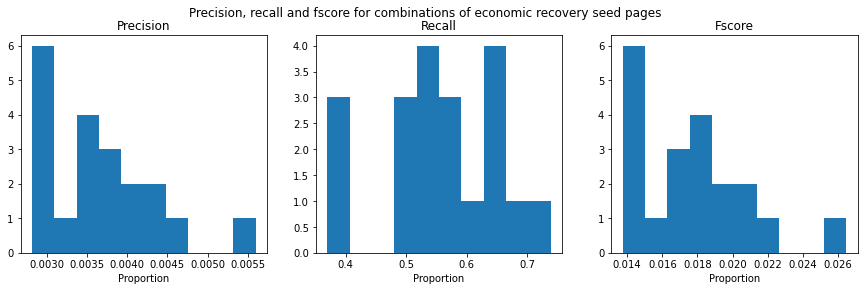

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle('Precision, recall and fscore for combinations of economic recovery seed pages')
ax[0].hist(ps);
ax[0].set_title("Precision");
ax[0].set_xlabel("Proportion");
ax[1].hist(rs);
ax[1].set_title("Recall");
ax[1].set_xlabel("Proportion");
ax[2].hist(fs);
ax[2].set_title("Fscore");
ax[2].set_xlabel("Proportion");

In [ ]:
np.mean([ps,rs,fs], axis=1)

array([0.0036429 , 0.55543478, 0.01771588])

In [ ]:
sorted(list(zip(fs, er_seed_samples)), key=lambda x: -x[0])[:5]

[(0.026478375992939097,
  ('/become-apprentice/pay-and-conditions',
   '/browse/benefits/looking-for-work',
   '/advanced-learner-loan/how-to-apply')),
 (0.02205882352941177,
  ('/guidance/international-trade-products-and-schemes',
   '/become-apprentice/pay-and-conditions',
   '/sign-in-childcare-account')),
 (0.021328958162428215,
  ('/universal-credit/other-financial-support',
   '/am-i-getting-minimum-wage',
   '/education/further-and-higher-education-courses-and-qualifications')),
 (0.020885547201336674,
  ('/business-finance-support',
   '/education/further-and-higher-education-courses-and-qualifications',
   '/government/publications/find-a-skills-bootcamp/list-of-skills-bootcamps')),
 (0.019641825534373197,
  ('/guidance/redundancy-help-finding-work-and-claiming-benefits',
   '/find-traineeship',
   '/education/further-and-higher-education-courses-and-qualifications'))]

Mean precision is 0.0036, recall is 0.555 and fscore is 0.0177. Hence we find an additional 7 ER pages on average, with only a small drop in precision.

### Sensitivity to choice of M and N

The choice of M and N will affect performance. Here we test the performance per choice of M and N with a factorial experiment. We'll evaluate this on the best combination of ER seed pages found previously: 

('/become-apprentice/pay-and-conditions','/browse/benefits/looking-for-work','/advanced-learner-loan/how-to-apply')

It's very time consuming to do this experiment, so we'll just do this for ER, since it's a smaller WUJ (according to the number of pages in the curated list).

In [ ]:
seeds = (
    '/become-apprentice/pay-and-conditions',
    '/browse/benefits/looking-for-work',
    '/advanced-learner-loan/how-to-apply')

# number of steps to take in random walk
Ns = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600]

# number of times to initialise random walk from a given seed node
Ms = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600]

results = rw.M_N_Experiment(Ns,Ms,A,G,er_pages,seeds,proba=False,n_jobs=-1)
results_df = pd.DataFrame.from_records(results, columns=['precision', 'recall', 'fscore', 'repeats', 'steps', 'pages_visited'])
results_df.to_csv('../../data/processed/er_rw_mn_experiment.csv')

  0%|          | 0/225 [00:00<?, ?it/s]

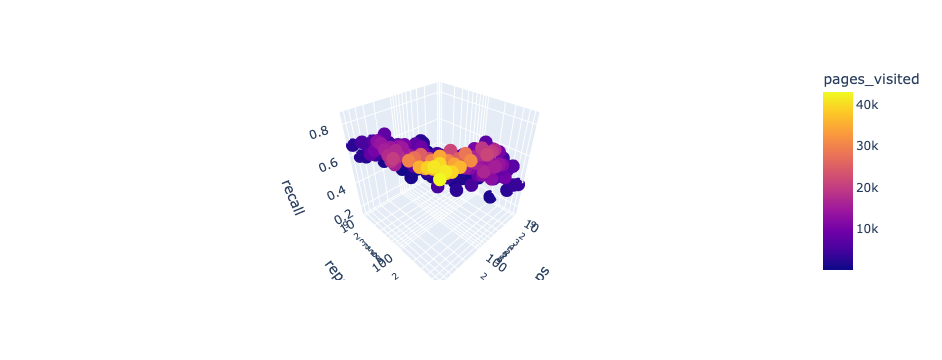

In [ ]:
results_df = pd.read_csv('../../data/processed/er_rw_mn_experiment.csv')

fig = px.scatter_3d(results_df, x='steps', y='repeats', z='recall', color='pages_visited', log_x=True, log_y=True)
fig.show()

# Biased random walks

Previously, transition probabilities were uniformly distributed. Hence, the random walk treated all neighbouring nodes as equal. In reality, information from the random walk so far can inform which node to transition to. Now, transition probabilities will be biased using such information, to increase the probability of moving towards nodes that are more relevant to a WUJ.

## Node2vec, constrained by existing edges

Need the n2v_node_embeddings_weighted_Nov12 embeddings from here: https://drive.google.com/file/d/1ai2eAmAO0S13U8JQN2_RhTPFrHQv6JJh/view?usp=sharing

In [ ]:
n2v = pd.read_csv('../../data/processed/n2v_node_embeddings_weighted_Nov12',
                  sep=' ',
                  skiprows=1,
                  header=None)

n2v.rename(columns={0:'cid'}, inplace=True)
n2v['vec'] = n2v.iloc[:,1:].values.tolist()
n2v['vec'] = n2v['vec'].apply(np.array)
n2v.drop(n2v.columns[1:-1], axis=1, inplace=True)

n2v.head()

,cid,vec
0,2977d3b7-e44d-4200-beb3-b3ea4eae9267,"[1.6464752, 1.0051225, 3.237041, -0.44560647, ..."
1,5efc1f67-7631-11e4-a3cb-005056011aef,"[-4.002749, 1.058231, 0.87883013, 4.767709, 0...."
2,78349e7d-21b5-4ae0-8d10-847d613280fe,"[-0.61908114, 2.5806224, 0.619022, 2.722821, -..."
3,632d1ae0-0340-4a23-87b0-595bb596e5f4,"[-1.0961137, 3.7542048, -0.54589766, 3.0593545..."
4,774cee22-d896-44c1-a611-e3109cce8eae,"[-1.542265, 2.7675521, -0.00036232924, 5.50759..."


In [ ]:
node_ids = pd.DataFrame({
                        'node_id': [n[0] for n in list(G.nodes(data=True))],
                        'cid': [n[1]['properties']['contentID'] for n in list(G.nodes(data=True))]
                        })
node_ids.head()

,node_id,cid
0,488294,c5acf4c3-8a8c-49e1-8d14-5e61fbb1f3c8
1,450289,b1a3bd0c-5da6-4139-b362-9ee40dd50b50
2,47721,19003dea-8169-414a-a18c-7e51366ec08f
3,592592,fc70b57d-a8be-4a95-a7fb-ca15451e8b32
4,466487,ba321772-bc46-49ee-8a6f-85f21ed5957b


In [ ]:
n2v = n2v.merge(node_ids, on='cid')
n2v.head()

,cid,vec,node_id
0,2977d3b7-e44d-4200-beb3-b3ea4eae9267,"[1.6464752, 1.0051225, 3.237041, -0.44560647, ...",1062
1,5efc1f67-7631-11e4-a3cb-005056011aef,"[-4.002749, 1.058231, 0.87883013, 4.767709, 0....",5158
2,78349e7d-21b5-4ae0-8d10-847d613280fe,"[-0.61908114, 2.5806224, 0.619022, 2.722821, -...",694
3,632d1ae0-0340-4a23-87b0-595bb596e5f4,"[-1.0961137, 3.7542048, -0.54589766, 3.0593545...",99
4,632d1ae0-0340-4a23-87b0-595bb596e5f4,"[-1.0961137, 3.7542048, -0.54589766, 3.0593545...",256


In [ ]:
G2 = G2.subgraph(n2v.node_id).copy()

# remove any possible nodes that refer to themselves
G2.remove_edges_from(nx.selfloop_edges(G2))

In [ ]:
# add node2vec vectors as properties in each node
for row in n2v.iterrows():
    # row[1][2] stores the node_id in each n2v row
    # row[1][1] stores the node2vec embedding of this node
    G2.nodes[row[1][2]]['n2v'] = row[1][1]

In [ ]:
G2_nodes = np.array(G2.nodes(data=True))

Some ER and SaB pages do not have node2vec embeddings available, hence we'll remove those for now:

In [ ]:
G2_pages = [node[1]['properties']['name'] for node in G2_nodes]
er_pages_2 = [page for page in er_pages if page in G2_pages]
len(er_pages_2)

34

#### Compute transition probabilities

In [ ]:
from numpy import dot
from numpy.linalg import norm
from scipy.sparse import csr_matrix

# get adjacency matrix
A2 = nx.adj_matrix(G2, weight=None)

# initialise transitiobn matrix
T2 = csr_matrix(A2.shape)

for i in tqdm(range(A2.shape[0])):
    
    # get indexes of neighbouring nodes
    neighbours = np.nonzero(A2[i])[1]
    
    # skip nodes without neighbours
    if neighbours.size == 0:
        continue
    
    # get n2v vectors of neighbouring nodes
    neighbour_n2v = np.array([node[1]['n2v'] for node in G2_nodes[neighbours]])
    
    # get n2v vector of current node
    current_n2v = G2_nodes[i][1]['n2v']
    
    # use n2v vectors to compute cosine similarities between current node and its neighbours
    #cosine_sims = (neighbour_n2v @ current_n2v)/(norm(neighbour_n2v, axis=1) * norm(current_n2v))
    
    # use n2v vectors to compute dot product between current node and its neighbours
    dot_prod = (neighbour_n2v @ current_n2v)
    
    # transition probabilities
    # softmax with base 1.025
    ps = 1.025**(dot_prod)/sum(1.025**(dot_prod))
    
    # insert transition probabilities into transition matrix
    T2[i, neighbours] = ps 

  0%|          | 0/9662 [00:00<?, ?it/s]

/Users/jakerutherford/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


## Repeated random walks

### Multiple seed nodes

#### Start a business

In [ ]:
sab_seed_samples = sample(list(combinations(er_pages_2,3)),20)

In [ ]:
ps = []
rs = []
fs = []

for seed_sample in tqdm(sab_seed_samples):
    result = rw.repeat_random_walks(500,10,T2,G2,seed_sample,proba=True,combine='union',level=1,verbose=0,n_jobs=-1)
    p,r,f = rw.evaluate(sab_pages, result['pages_visited'])
    ps.append(p)
    rs.append(r)
    fs.append(f)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle('Precision, recall and fscore for combinations of SaB seed pages')
ax[0].hist(ps);
ax[0].set_title("Precision");
ax[0].set_xlabel("Proportion");
ax[1].hist(rs);
ax[1].set_title("Recall");
ax[1].set_xlabel("Proportion");
ax[2].hist(fs);
ax[2].set_title("Fscore");
ax[2].set_xlabel("Proportion");

#### Economic recovery

In [ ]:
er_seed_samples = sample(list(combinations(er_pages_2,3)),20)

Amongst the randomly selected combinations of seed node, we include a choice of 3 seed nodes from a domain expert to see if it provides results that are noticeably different from a random choice of 3 seed nodes.

In [ ]:
seeds = (
    '/find-a-job',
    '/universal-credit',
    '/government/collections/financial-support-for-businesses-during-coronavirus-covid-19'
)

er_seed_samples.append(seeds)

In [ ]:
ps = []
rs = []
fs = []

for seed_sample in tqdm(er_seed_samples):
    result = rw.repeat_random_walks(500,10,T2,G2,seed_sample,proba=True,combine='union',level=1,verbose=0,n_jobs=-1)
    p,r,f = rw.evaluate(er_pages, result['pages_visited'])
    ps.append(p)
    rs.append(r)
    fs.append(f)

  0%|          | 0/21 [00:00<?, ?it/s]

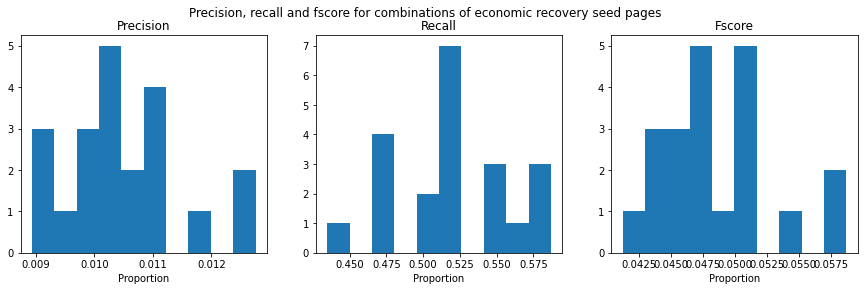

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle('Precision, recall and fscore for combinations of economic recovery seed pages')
ax[0].hist(ps);
ax[0].set_title("Precision");
ax[0].set_xlabel("Proportion");
ax[1].hist(rs);
ax[1].set_title("Recall");
ax[1].set_xlabel("Proportion");
ax[2].hist(fs);
ax[2].set_title("Fscore");
ax[2].set_xlabel("Proportion");

In [ ]:
np.mean([ps,rs,fs], axis=1)

array([0.01049476, 0.52173913, 0.04854907])

In [ ]:
sorted(list(zip(fs, er_seed_samples)), key=lambda x: -x[0])[:5]

[(0.05867014341590614,
  ('/support-visit-benefit-claim',
   '/browse/education/find-course',
   '/am-i-getting-minimum-wage')),
 (0.057243505063848524,
  ('/guidance/plan-for-jobs-skills-and-employment-programmes-information-for-employers',
   '/grant-bursary-adult-learners',
   '/further-education-courses')),
 (0.05352363960749331,
  ('/find-a-job', '/career-skills-and-training', '/advanced-learner-loan')),
 (0.05102040816326531,
  ('/guidance/claim-back-statutory-sick-pay-paid-to-employees-due-to-coronavirus-covid-19',
   '/find-traineeship',
   '/agricultural-skills-and-training')),
 (0.05062778452814904,
  ('/guidance/international-trade-products-and-schemes',
   '/universal-credit',
   '/am-i-getting-minimum-wage'))]

Without biasing transition probabilities, we had mean precision 0.0036, recall 0.555 and fscore 0.0177. After biasing, mean precision is 0.01, recall 0.52, fscore 0.049. Hence, much better precision by biasing probabilities.

The domain-expert-provided seed nodes provide slightly below average results, with an fscore of 0.045.

In [ ]:
[result for result in zip(fs, er_seed_samples) if result[1] == seeds]

[(0.04524886877828055,
  ('/find-a-job',
   '/universal-credit',
   '/government/collections/financial-support-for-businesses-during-coronavirus-covid-19'))]

### Sensitivity to number of repeats and steps

Here different combinations of repeats and steps are trialled in order to determine what values achieve the best results. To reduce computation time, this is focused on a choice of 3 seed nodes provided by domain experts, instead of averaging results across multiple randomly selected combinations of seed node.

In [ ]:
from itertools import combinations
from random import sample

seeds = (
    '/find-a-job',
    '/universal-credit',
    '/government/collections/financial-support-for-businesses-during-coronavirus-covid-19'
)

# number of steps to take in random walk
Ns = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600]

# number of times to initialise random walk from a given seed node
Ms = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600]

results = rw.M_N_Experiment(Ns,Ms,T2,G2,er_pages,seeds,proba=True,n_jobs=-1)
results_df = pd.DataFrame.from_records(results, columns=['precision', 'recall', 'fscore', 'repeats', 'steps', 'pages_visited'])
results_df.to_csv('..data/processed/er_brw_mn_experiment.csv')

  0%|          | 0/225 [00:00<?, ?it/s]

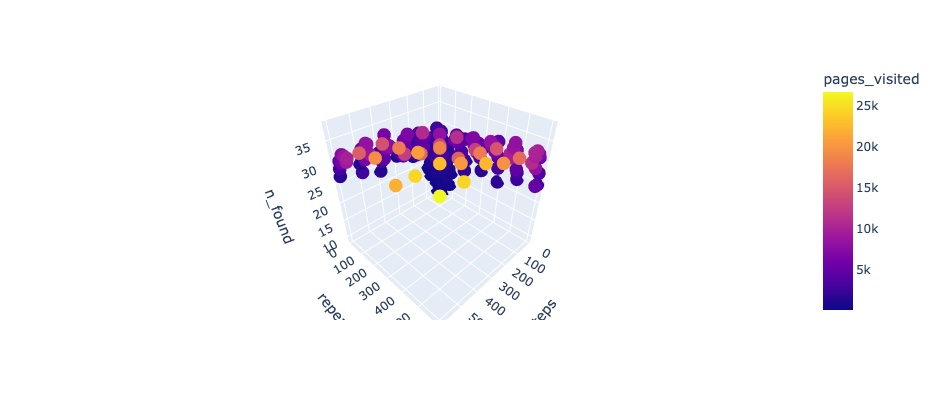

In [ ]:
results_df = pd.read_csv('..data/processed/er_brw_mn_experiment.csv')

results_df['n_found'] = results_df.recall * len(er_pages)

fig = px.scatter_3d(results_df, x='steps', y='repeats', z='n_found', color='pages_visited', width=500, height=400)
fig.show()

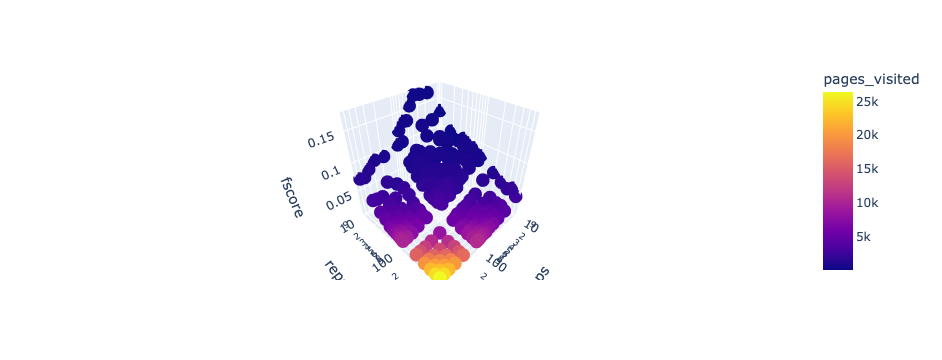

In [ ]:
fig = px.scatter_3d(results_df, x='steps', y='repeats', z='fscore', color='pages_visited', log_x=True, log_y=True)
fig.show()

## Node2vec, ignoring edges

When transitioning to a new node, we could instead look at a neighbourhood of nodes with nearby node2vec embeddings, instead of nodes which happen to have edges connected to the current node.

#### Compute transition probabilities

In [ ]:
from numpy import dot
from numpy.linalg import norm
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

print("Getting n2v embeddings")
# construct array of n2v embeddings, each row for a node
T3 = np.array([node[1]['n2v'] for node in G2_nodes])

# compute dot products between every embedding
#T3 = T3 @ T3.transpose()

print("Computing cosine similarity")
# compute cosine similarity between each row
T3 = cosine_similarity(T3, dense_output=True)

print("Filling diagonal with 0s")
# don't want to return to same node over and over, so set diagonal values to 0
np.fill_diagonal(T3, 0)

print("Computing softmax")
T3 = np.exp(T3)

# find values above the 99.99% percentile, to find a group of similar nodes around a node
# this also lets us create a sparse matrix by setting most values to 0
percentile = np.percentile(T3,99.99,axis=1)[:,None]
T3 = np.where(T3 >= percentile, T3, 0)

T3 = T3/T3.sum(axis=1)[:,None]

T3 = csr_matrix(T3)


Getting n2v embeddings
Computing cosine similarity
Filling diagonal with 0s
Computing softmax


In [ ]:
# saving the transition matrix since that took over an hour to compute
import pickle
with open('../../data/processed/T3.pickle', 'wb') as handle:
    pickle.dump(T3, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Economic recovery

In [ ]:
er_seed_samples = sample(list(combinations(er_pages_2,3)),2)

In [ ]:
seeds = (
    '/find-a-job',
    '/universal-credit',
    '/government/collections/financial-support-for-businesses-during-coronavirus-covid-19'
)

er_seed_samples.append(seeds)

In [ ]:
ps = []
rs = []
fs = []

for seed_sample in tqdm(er_seed_samples):
    result = rw.repeat_random_walks(50,50,T3,G2,seed_sample,proba=True,combine='union',level=1,verbose=0,n_jobs=-1)
    p,r,f = rw.evaluate(er_pages, result['pages_visited'])
    ps.append(p)
    rs.append(r)
    fs.append(f)

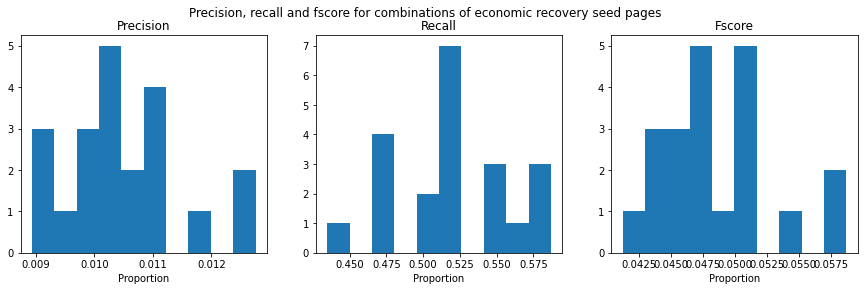

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle('Precision, recall and fscore for combinations of economic recovery seed pages')
ax[0].hist(ps);
ax[0].set_title("Precision");
ax[0].set_xlabel("Proportion");
ax[1].hist(rs);
ax[1].set_title("Recall");
ax[1].set_xlabel("Proportion");
ax[2].hist(fs);
ax[2].set_title("Fscore");
ax[2].set_xlabel("Proportion");

# Page view + random walks

## Unbiased

In [ ]:
# get networkx graph
G = nx.read_gpickle("../../data/processed/functional_session_hit_directed_graph_er.gpickle")

# get economic recovery pages
# Import the data from google sheets
spreadsheet_key = '1lLsgQRsl4bXmbyiwrbMNQOR_Zu-FkbqYRUmOOhTYc70' 
book = gc.open_by_key(spreadsheet_key)
worksheet = book.worksheet('Top pages') 
table = worksheet.get_all_values()

# Convert table data into a dataframe then set 
er_pages = list(set(pd.DataFrame(table[1:], columns=table[0]).pagePathv2))

# get er_pages that are actually in the subgraph
er_pages_2 = [page for page in er_pages if page in set(G.nodes())]

# get adjacency matrix of G
A = nx.adj_matrix(G, weight=None)

In [ ]:
# reformat the graph to make it compliant with existing random walk functions
# i.e. add the path to a name property and set the index to be a number

for index,data in G.nodes(data=True):
    data['properties'] = dict()
    data['properties']['name'] = index


G = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute=None)


In [ ]:
er_seed_samples = sample(list(combinations(er_pages,3)),5)

In [ ]:
ps = []
rs = []
fs = []

for seed_sample in tqdm(er_seed_samples):
    result = rw.repeat_random_walks(50,50,A,G,seed_sample,proba=False,combine='union',level=1,verbose=0,n_jobs=-1)
    p,r,f = rw.evaluate(er_pages, result['pages_visited'])
    ps.append(p)
    rs.append(r)
    fs.append(f)

  0%|          | 0/5 [00:00<?, ?it/s]

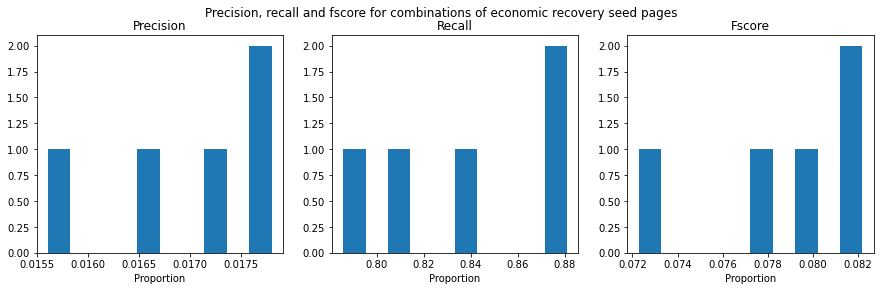

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle('Precision, recall and fscore for combinations of economic recovery seed pages')
ax[0].hist(ps);
ax[0].set_title("Precision");
ax[0].set_xlabel("Proportion");
ax[1].hist(rs);
ax[1].set_title("Recall");
ax[1].set_xlabel("Proportion");
ax[2].hist(fs);
ax[2].set_title("Fscore");
ax[2].set_xlabel("Proportion");

In [ ]:
np.mean([ps,rs,fs], axis=1)

array([0.01524403, 0.86190476, 0.07118389])

In [ ]:
sorted(list(zip(fs, er_seed_samples)), key=lambda x: -x[0])[:5]

[(0.08218569524655708,
  ('/employing-an-apprentice',
   '/support-visit-benefit-claim',
   '/become-apprentice')),
 (0.0818094321462945,
  ('/how-to-claim-universal-credit',
   '/grant-bursary-adult-learners',
   '/browse/benefits/looking-for-work')),
 (0.07961783439490445,
  ('/jobseekers-allowance', '/find-a-job', '/career-skills-and-training')),
 (0.07724425887265135,
  ('/browse/education',
   '/find-traineeship',
   '/agricultural-skills-and-training')),
 (0.07227332457293036,
  ('/moving-from-benefits-to-work',
   '/access-to-work',
   '/budgeting-help-benefits'))]

In [ ]:
from itertools import combinations
from random import sample

seeds = (
    '/find-a-job',
    '/universal-credit',
    '/government/collections/financial-support-for-businesses-during-coronavirus-covid-19'
)

# number of steps to take in random walk
Ns = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600]

# number of times to initialise random walk from a given seed node
Ms = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600]

results = rw.M_N_Experiment(Ns,Ms,A,G,er_pages,seeds,proba=False,n_jobs=-2)
results_df = pd.DataFrame.from_records(results, columns=['precision', 'recall', 'fscore', 'repeats', 'steps', 'pages_visited'])

  0%|          | 0/225 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '..data/processed/pv_er_rw_mn_experiment.csv'

In [ ]:
results_df.to_csv('../../data/processed/pv_er_rw_mn_experiment.csv')

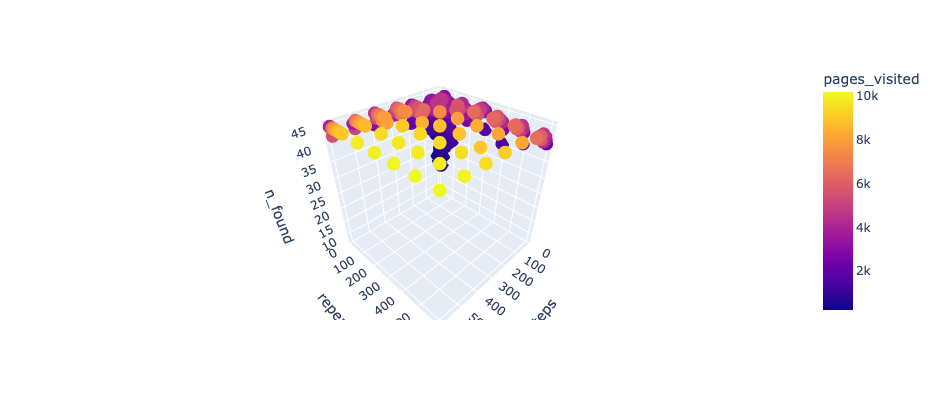

In [ ]:
results_df = pd.read_csv('../../data/processed/pv_er_rw_mn_experiment.csv')

results_df['n_found'] = results_df.recall * len(er_pages)

fig = px.scatter_3d(results_df, x='steps', y='repeats', z='n_found', color='pages_visited', width=500, height=400)
fig.show()

In [ ]:
from itertools import combinations
from random import sample

seeds = (
    '/find-a-job',
    '/universal-credit',
    '/government/collections/financial-support-for-businesses-during-coronavirus-covid-19'
)

# number of steps to take in random walk
Ns = [10,20,30,40,50,60,70,80,90,100]

# number of times to initialise random walk from a given seed node
Ms = [10,20,30,40,50,60,70,80,90,100]

results = rw.M_N_Experiment(Ns,Ms,A,G,er_pages,seeds,proba=False,n_jobs=-2)
results_df = pd.DataFrame.from_records(results, columns=['precision', 'recall', 'fscore', 'repeats', 'steps', 'pages_visited'])
results_df.to_csv('../../data/processed/pv_er_rw_mn_experiment_2.csv')

  0%|          | 0/100 [00:00<?, ?it/s]

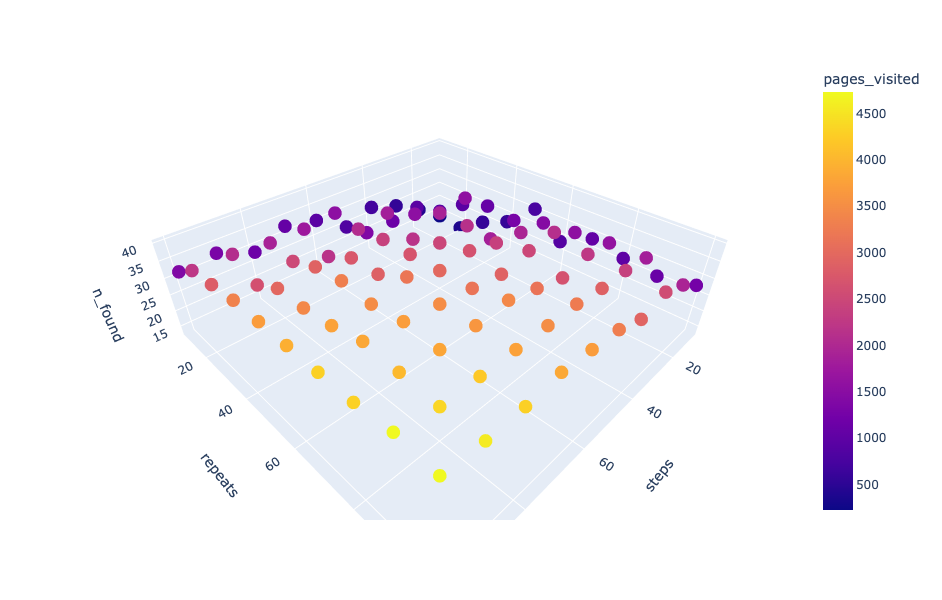

In [ ]:
results_df = pd.read_csv('../../data/processed/pv_er_rw_mn_experiment_2.csv')

results_df['n_found'] = results_df.recall * len(set(er_pages))

fig = px.scatter_3d(results_df, x='steps', y='repeats', z='n_found', color='pages_visited', width=1200, height=600)
fig.show()

In [ ]:
results_df[(results_df.n_found > 30) & (results_df.pages_visited <= 2000)].sort_values(['n_found','pages_visited'], ascending=[False, True])

,Unnamed: 0,precision,recall,fscore,repeats,steps,pages_visited,n_found
32,32,0.024142,0.904762,0.109070,40,30,1574,38.0
15,15,0.023856,0.880952,0.107621,20,60,1551,37.0
24,24,0.020219,0.880952,0.092593,30,50,1830,37.0
33,33,0.019341,0.880952,0.088900,40,40,1913,37.0
71,71,0.022167,0.857143,0.100446,80,20,1624,36.0
16,16,0.020702,0.857143,0.094389,20,70,1739,36.0
81,81,0.019608,0.857143,0.089820,90,20,1836,36.0
17,17,0.018977,0.857143,0.087167,20,80,1897,36.0
61,61,0.022508,0.833333,0.101567,70,20,1555,35.0
52,52,0.018069,0.833333,0.083135,60,30,1937,35.0


## Biased

In [ ]:
# get networkx graph
G2 = nx.read_gpickle("../../data/processed/functional_session_hit_directed_graph_er_cid.gpickle")

# get adjacency matrix of G
A2 = nx.adj_matrix(G2, weight=None)

In [ ]:
# reformat the graph to make it compliant with existing random walk functions
# i.e. add the path to a name property and set the index to be a number

for index,data in G2.nodes(data=True):
    data['properties'] = dict()
    data['properties']['name'] = index


G2 = nx.convert_node_labels_to_integers(G2, first_label=0, ordering='default', label_attribute=None)


In [ ]:
list(G2.nodes(data=True))[:3]

[(0,
  {'sessionHits': 39089,
   'cid': 'f3bbdec2-0e62-4520-a7fd-6ffd5d36e03a',
   'properties': {'name': '/'}}),
 (1,
  {'sessionHits': 18787,
   'cid': 'dd395436-9b40-41f3-8157-740a453ac972',
   'properties': {'name': '/search/all'}}),
 (2,
  {'sessionHits': 13167,
   'cid': 'bfcba1a4-87ba-496d-9b90-2b5f4deb8a06',
   'properties': {'name': '/view-prove-immigration-status'}})]

In [ ]:
n2v = pd.read_csv('../../data/processed/n2v_node_embeddings_weighted_Nov12',
                  sep=' ',
                  skiprows=1,
                  header=None)

n2v.rename(columns={0:'cid'}, inplace=True)
n2v['vec'] = n2v.iloc[:,1:].values.tolist()
n2v['vec'] = n2v['vec'].apply(np.array)
n2v.drop(n2v.columns[1:-1], axis=1, inplace=True)

n2v.head()

,cid,vec
0,2977d3b7-e44d-4200-beb3-b3ea4eae9267,"[1.6464752, 1.0051225, 3.237041, -0.44560647, ..."
1,5efc1f67-7631-11e4-a3cb-005056011aef,"[-4.002749, 1.058231, 0.87883013, 4.767709, 0...."
2,78349e7d-21b5-4ae0-8d10-847d613280fe,"[-0.61908114, 2.5806224, 0.619022, 2.722821, -..."
3,632d1ae0-0340-4a23-87b0-595bb596e5f4,"[-1.0961137, 3.7542048, -0.54589766, 3.0593545..."
4,774cee22-d896-44c1-a611-e3109cce8eae,"[-1.542265, 2.7675521, -0.00036232924, 5.50759..."


In [ ]:
node_ids = pd.DataFrame({
                        'node_id': [n[0] for n in list(G2.nodes(data=True))],
                        'cid': [n[1]['cid'] for n in list(G2.nodes(data=True))]
                        })
node_ids.head()

,node_id,cid
0,0,f3bbdec2-0e62-4520-a7fd-6ffd5d36e03a
1,1,dd395436-9b40-41f3-8157-740a453ac972
2,2,bfcba1a4-87ba-496d-9b90-2b5f4deb8a06
3,3,None
4,4,03531ffd-314b-4fed-9361-fa9816005c31


In [ ]:
n2v = n2v.merge(node_ids, on='cid')
n2v.head()

,cid,vec,node_id
0,2977d3b7-e44d-4200-beb3-b3ea4eae9267,"[1.6464752, 1.0051225, 3.237041, -0.44560647, ...",1062
1,5efc1f67-7631-11e4-a3cb-005056011aef,"[-4.002749, 1.058231, 0.87883013, 4.767709, 0....",5158
2,78349e7d-21b5-4ae0-8d10-847d613280fe,"[-0.61908114, 2.5806224, 0.619022, 2.722821, -...",694
3,632d1ae0-0340-4a23-87b0-595bb596e5f4,"[-1.0961137, 3.7542048, -0.54589766, 3.0593545...",99
4,632d1ae0-0340-4a23-87b0-595bb596e5f4,"[-1.0961137, 3.7542048, -0.54589766, 3.0593545...",256


In [ ]:
G2 = G2.subgraph(n2v.node_id).copy()

# remove any possible nodes that refer to themselves
G2.remove_edges_from(nx.selfloop_edges(G2))

In [ ]:
# add node2vec vectors as properties in each node
for row in n2v.iterrows():
    # row[1][2] stores the node_id in each n2v row
    # row[1][1] stores the node2vec embedding of this node
    G2.nodes[row[1][2]]['n2v'] = row[1][1]

In [ ]:
G2_nodes = np.array(G2.nodes(data=True))

In [ ]:
G2_pages = [node[1]['properties']['name'] for node in G2_nodes]
er_pages_2 = [page for page in er_pages if page in G2_pages]
len(er_pages_2)

34

In [ ]:
from numpy import dot
from numpy.linalg import norm
from scipy.sparse import csr_matrix

# get adjacency matrix
A2 = nx.adj_matrix(G2, weight=None)

# initialise transitiobn matrix
T2 = csr_matrix(A2.shape)

for i in tqdm(range(A2.shape[0])):
    
    # get indexes of neighbouring nodes
    neighbours = np.nonzero(A2[i])[1]
    
    # skip nodes without neighbours
    if neighbours.size == 0:
        continue
    
    # get n2v vectors of neighbouring nodes
    neighbour_n2v = np.array([node[1]['n2v'] for node in G2_nodes[neighbours]])
    
    # get n2v vector of current node
    current_n2v = G2_nodes[i][1]['n2v']
    
    # use n2v vectors to compute cosine similarities between current node and its neighbours
    #cosine_sims = (neighbour_n2v @ current_n2v)/(norm(neighbour_n2v, axis=1) * norm(current_n2v))
    
    # use n2v vectors to compute dot product between current node and its neighbours
    dot_prod = (neighbour_n2v @ current_n2v)
    
    # transition probabilities
    # softmax with base 1.025
    ps = 1.025**(dot_prod)/sum(1.025**(dot_prod))
    
    # insert transition probabilities into transition matrix
    T2[i, neighbours] = ps 

  0%|          | 0/9662 [00:00<?, ?it/s]

/Users/jakerutherford/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


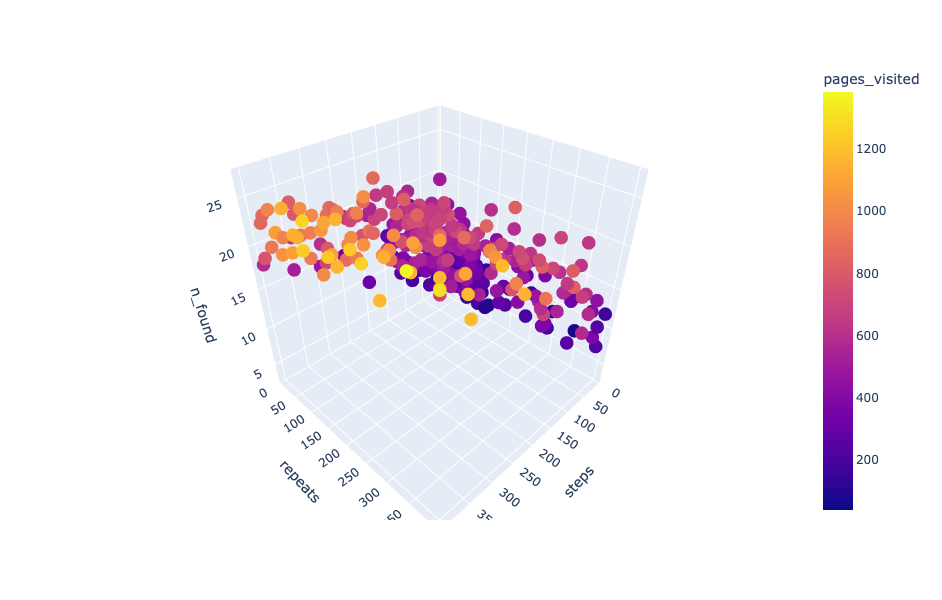

In [ ]:
results_df = pd.read_csv('../../data/processed/pv_er_brw_mn_experiment_2.csv')

results_df['n_found'] = results_df.recall * len(set(er_pages))

fig = px.scatter_3d(results_df, x='steps', y='repeats', z='n_found', color='pages_visited', width=1200, height=600)
fig.show()

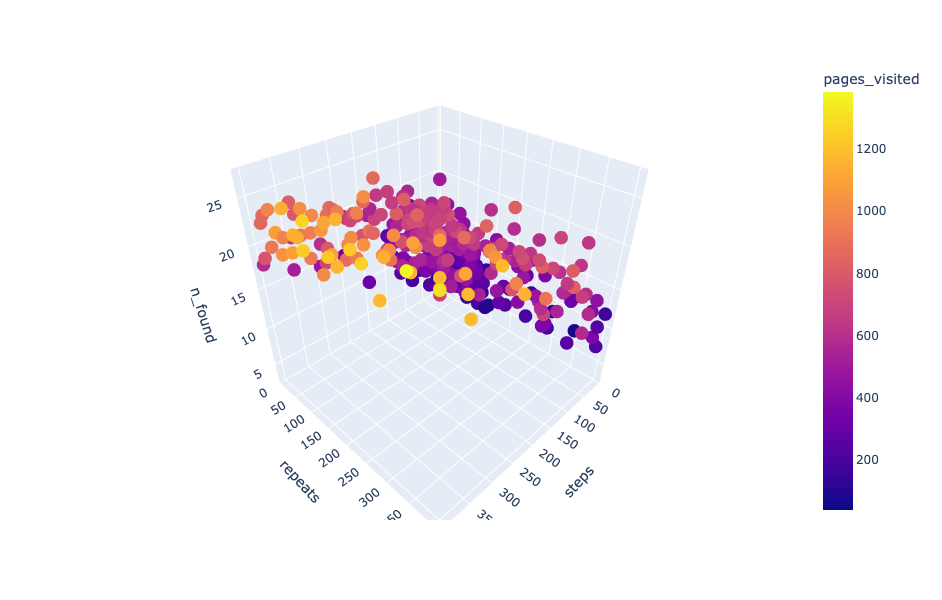

In [ ]:
results_df = pd.read_csv('../../data/processed/pv_er_brw_mn_experiment_2.csv')

results_df['n_found'] = results_df.recall * len(set(er_pages))

fig = px.scatter_3d(results_df, x='steps', y='repeats', z='n_found', color='pages_visited', width=1200, height=600)
fig.show()